# An Investigation of US Flights from 2008 <br/>
### by modhi alhabradi

### Introduction<br/>
This dataset reports flights in the United States, including carriers, arrival and departure delays, and reasons for delays, for 2008. Data links:<br/>

Statistical Computing | Statistical Graphics: http://stat-computing.org/dataexpo/2009/the-data.html<br/>

The flight data may provide insight into what time of year to avoid traveling within the US based on delays and cancellations.<br/> We can also investigate where, or which airports, offer the best (or worst) flight experiences based on similar issues.<br/> Additionally, it may be interesting to understand why flights that are cancelled get cancelled and how long a delay take before becoming a cancellation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

### Data Wrangling<br/>
In this section of the report, we load in the data, check for cleanliness, and then trim and clean the dataset for analysis.

In [2]:
df_full = pd.read_csv('2008.csv')
df_full.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,...,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,3.0,10.0,0,NaN,0,2.0,0.0,0.0,0.0,32.0


In [3]:
df_full.shape

(7009728, 29)

In [4]:
# Before inital exploration and cleaning begins, make a copy of the original dataframe:
df = df_full.copy()

In [5]:
# Basic column info/ data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009728 entries, 0 to 7009727
Data columns (total 29 columns):
Year                 int64
Month                int64
DayofMonth           int64
DayOfWeek            int64
DepTime              float64
CRSDepTime           int64
ArrTime              float64
CRSArrTime           int64
UniqueCarrier        object
FlightNum            int64
TailNum              object
ActualElapsedTime    float64
CRSElapsedTime       float64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin               object
Dest                 object
Distance             int64
TaxiIn               float64
TaxiOut              float64
Cancelled            int64
CancellationCode     object
Diverted             int64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
dtypes: float64(14), int64(10), object(5)
memory usage: 1.5+ GB


In [7]:
# Number of Nulls per Column
df.isna().sum()

Year                       0
Month                      0
DayofMonth                 0
DayOfWeek                  0
DepTime               136246
CRSDepTime                 0
ArrTime               151649
CRSArrTime                 0
UniqueCarrier              0
FlightNum                  0
TailNum                83365
ActualElapsedTime     154699
CRSElapsedTime           844
AirTime               154699
ArrDelay              154699
DepDelay              136246
Origin                     0
Dest                       0
Distance                   0
TaxiIn                151649
TaxiOut               137058
Cancelled                  0
CancellationCode     6872294
Diverted                   0
CarrierDelay         5484993
WeatherDelay         5484993
NASDelay             5484993
SecurityDelay        5484993
LateAircraftDelay    5484993
dtype: int64

There are many fields with missing values; some will be replaced with zeros, but some (like DepTime and ArrTime) need to be investigated to understand if they are cancellations or errors.

In [8]:
# Origin Airports
df.Origin.value_counts()[0:10]

ATL    414513
ORD    350380
DFW    281281
DEN    241443
LAX    215608
PHX    199408
IAH    185172
LAS    172876
DTW    161989
SFO    140587
Name: Origin, dtype: int64

In [9]:
# Destination Airports
df.Dest.value_counts()[0:10]

ATL    414521
ORD    350452
DFW    281401
DEN    241470
LAX    215685
PHX    199416
IAH    185160
LAS    172871
DTW    162000
SFO    140579
Name: Dest, dtype: int64

In [10]:
# Unique Carrier Counts
df.UniqueCarrier.value_counts()

WN    1201754
AA     604885
OO     567159
MQ     490693
US     453589
DL     451931
UA     449515
XE     374510
NW     347652
CO     298455
EV     280575
9E     262208
FL     261684
YV     254930
OH     197607
B6     196091
AS     151102
F9      95762
HA      61826
AQ       7800
Name: UniqueCarrier, dtype: int64

## Assessment for Cleaning Steps:<br/>
DepTime, CRSDepTime, ArrTime, and CRSArrTime are floats/ints, but need to represent local, hhmm <br/>
If no cancellation, CancellationCode should be E instead of NAN<br/>
CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay should have 0 instead of NAN<br/>
Need to understand how DepTime, ArrTime, and AirTime, ActualElapsedTime and CRSElapsedTime can be null - were those flights cancelled?<br/>

### Data Cleaning Steps:
Replace NaNs in CancellationCode with the letter 'E'

In [11]:
# Confirm that when a flight is NOT cancelled, the cancellation code is NaN
df[df.Cancelled==0].CancellationCode.unique()

array([nan], dtype=object)

In [12]:
# Fill CancellationCode NaN's with 'E' to match the rest of the codes
values = {'CancellationCode': 'E'}
df.fillna(value=values, inplace=True)

In [13]:
# Check that all nulls are gone
df.CancellationCode.value_counts(dropna=False)

E    6872294
B      54904
A      54330
C      28188
D         12
Name: CancellationCode, dtype: int64

### Recast DepTime, CRSDepTime, ArrTime, and CRSArrTime as timestamps

In [14]:
time_col = ['DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime']
# fill nulls with 9999 to distinguish from actual times
values = {'DepTime': 9999, 'CRSDepTime': 9999, 'ArrTime': 9999, 'CRSArrTime': 9999}
df.fillna(value=values, inplace=True)

In [15]:
# convert values to strings
df[time_col] = df[time_col].astype(int).astype(str)

In [16]:
# front-pad strings with 0's so all strings have 4 digits for hh mm
def padzero(s):
    timel = len(s)
    if timel < 4:
        add0 = 4 - timel
        return add0*'0'+s
    else:
        return s
    
for col in time_col:
    df[col] = df[col].apply(lambda x: padzero(x))

In [17]:
# convert to datetime with format '%H%M'.time()
for col in time_col:
    df[col] = pd.to_datetime(df[col], format='%H%M', errors='coerce').dt.time

In [18]:
# Check that all times are hours and minutes now
df[time_col]

,DepTime,CRSDepTime,ArrTime,CRSArrTime
0,20:03:00,19:55:00,22:11:00,22:25:00
1,07:54:00,07:35:00,10:02:00,10:00:00
2,06:28:00,06:20:00,08:04:00,07:50:00
3,09:26:00,09:30:00,10:54:00,11:00:00
4,18:29:00,17:55:00,19:59:00,19:25:00
5,19:40:00,19:15:00,21:21:00,21:10:00
6,19:37:00,18:30:00,20:37:00,19:40:00
7,10:39:00,10:40:00,11:32:00,11:50:00
8,06:17:00,06:15:00,06:52:00,06:50:00
9,16:20:00,16:20:00,16:39:00,16:55:00


## Remove rows where flight was not cancelled but there is no flight time

In [19]:
# Indices where Cancelled = False and Elapsed Time is null
to_remove = df[(df.Cancelled==0) & (df.ActualElapsedTime.isnull())].index
# Remove these indices from the dataframe
df.drop(index=to_remove, inplace=True)

# Check if the shape changed correctly
df.shape

(6992463, 29)

## Replace numeric nulls with 0


In [20]:
# identify numeric nulls again
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

num_col = df.select_dtypes(include=numerics).columns 
num_col

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'Diverted',
       'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'LateAircraftDelay'],
      dtype='object')

In [21]:
# Check if nulls only occur when flights are cancelled
df[df.Cancelled==1].isna().sum()

Year                      0
Month                     0
DayofMonth                0
DayOfWeek                 0
DepTime              136246
CRSDepTime                0
ArrTime              137434
CRSArrTime                0
UniqueCarrier             0
FlightNum                 0
TailNum               83358
ActualElapsedTime    137434
CRSElapsedTime          246
AirTime              137434
ArrDelay             137434
DepDelay             136246
Origin                    0
Dest                      0
Distance                  0
TaxiIn               137434
TaxiOut              137058
Cancelled                 0
CancellationCode          0
Diverted                  0
CarrierDelay         137434
WeatherDelay         137434
NASDelay             137434
SecurityDelay        137434
LateAircraftDelay    137434
dtype: int64

In [22]:
# Identify nulls where flights were not cancelled
df[df.Cancelled==0].isna().sum()

Year                       0
Month                      0
DayofMonth                 0
DayOfWeek                  0
DepTime                  521
CRSDepTime                 0
ArrTime                 2668
CRSArrTime                 0
UniqueCarrier              0
FlightNum                  0
TailNum                    5
ActualElapsedTime          0
CRSElapsedTime             0
AirTime                    0
ArrDelay                   0
DepDelay                   0
Origin                     0
Dest                       0
Distance                   0
TaxiIn                     0
TaxiOut                    0
Cancelled                  0
CancellationCode           0
Diverted                   0
CarrierDelay         5330294
WeatherDelay         5330294
NASDelay             5330294
SecurityDelay        5330294
LateAircraftDelay    5330294
dtype: int64

In [23]:
# Delays and elapsed times and taxi times are replaced with zeros
values = {'CarrierDelay':0, 'WeatherDelay':0, 
          'NASDelay':0, 'SecurityDelay':0, 
          'LateAircraftDelay':0, 'AirTime': 0,
          'ArrDelay': 0, 'DepDelay': 0,
          'TaxiIn': 0, 'TaxiOut': 0,
          'ActualElapsedTime': 0, 'CRSElapsedTime': 0}
df.fillna(value=values, inplace=True)

# ArrTime and DepTime will be replaced with CRSArrTime and CRSDepTime respectively
values2 = {'ArrTime': df['CRSArrTime'], 'DepTime': df['CRSDepTime']}
df.fillna(value=values2, inplace=True)

In [24]:
# Check for nulls - all clean except TailNum, which is not necessary for this analysis
df.isna().sum()

Year                     0
Month                    0
DayofMonth               0
DayOfWeek                0
DepTime                  0
CRSDepTime               0
ArrTime                  0
CRSArrTime               0
UniqueCarrier            0
FlightNum                0
TailNum              83363
ActualElapsedTime        0
CRSElapsedTime           0
AirTime                  0
ArrDelay                 0
DepDelay                 0
Origin                   0
Dest                     0
Distance                 0
TaxiIn                   0
TaxiOut                  0
Cancelled                0
CancellationCode         0
Diverted                 0
CarrierDelay             0
WeatherDelay             0
NASDelay                 0
SecurityDelay            0
LateAircraftDelay        0
dtype: int64

## Eliminate extra Origin Airport

In [25]:
# One extra Origin airport
set(df.Origin.value_counts().index) - set(df.Dest.value_counts().index)

{'PUB'}

In [26]:
# Only two examples == neglibile for this analysis
df[df.Origin=='PUB']

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
3701794,2008,7,8,2,17:40:00,16:55:00,18:14:00,17:04:00,XE,104,...,5.0,18.0,0,E,0,0.0,45.0,25.0,0.0,0.0
3702095,2008,7,14,1,13:31:00,13:22:00,14:49:00,13:31:00,XE,117,...,8.0,41.0,0,E,0,0.0,9.0,69.0,0.0,0.0


In [27]:
# Remove unnecessary rows with PUB airport
df = df[df.Origin!='PUB']

## Exploratory Data Analysis <br/>
### Over-arching Question: What are the causes of cancellations, and can we avoid getting on a cancelled flight?<br/>
How many flights were cancelled in 2008?<br/>
What is the most common reason for cancellation?<br/>
Where do cancellations occur?<br/>
When do the most delays occur?
Month? Day? Hour?<br/>
Does a certain carrier have more cancellations?<br/>

### Cancelled vs Not Cancelled Flights

In [28]:
cc = df['Cancelled'].value_counts()
cc

0    6855027
1     137434
Name: Cancelled, dtype: int64

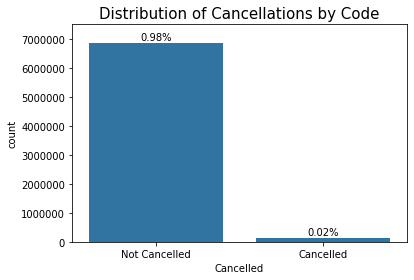

In [29]:
base_color = sb.color_palette()[0]
ax = sb.countplot(data = df, x = 'Cancelled', 
             color = base_color);
plt.ylim([0, 7500000])

# add annotations
n = df.shape[0]
cat_counts = df['Cancelled'].value_counts()
locs, labels = plt.xticks() # get the current tick locations and labels
cat_counts
# loop through each pair of locations and labels
for loc, label in zip(locs, labels):
    # get the text property for the label to get the correct count
    count = cat_counts[int(label.get_text())]
    ct_string = '{:0.2f}%'.format(count/n)
    plt.text(loc, count+100000, ct_string, ha = 'center', color = 'k')
    
plt.xticks([0, 1], ['Not Cancelled', 'Cancelled']);
plt.title('Distribution of Cancellations by Code', fontsize=15);

A large majority of flights were successful, while only a small number were cancelled. We'll mainly focus on just the cancelled flights (or relative number of cancelled flights by category) to see if we can determine where (by airline) most flights are cancelled, why (by cancellation code), and when (by month).

#### Subsets of Cancelled or Not Cancelled Flights

In [30]:
# Create a subset of the data for cancelled flights:
df_cancelled = df.query('(Cancelled==1)')
df_notcancelled = df.query('(Cancelled==0)')
print('There were {:0.0f} cancelled flights out of {:0.0f} total flights in 2008'.format(df_cancelled.shape[0], df.shape[0]))

There were 137434 cancelled flights out of 6992461 total flights in 2008


#### Distribution of Cancellation Codes

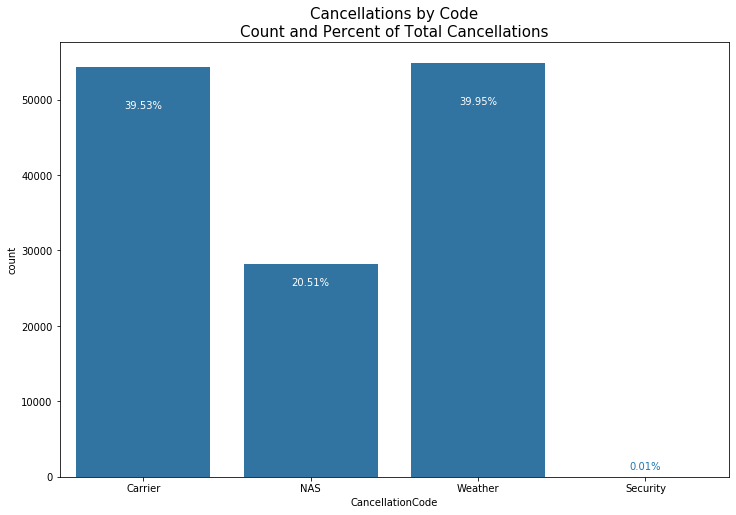

In [31]:
plt.figure(figsize=(12,8));
# Distribution of cancellation codes
cancel_codes = ['Carrier', 'NAS', 'Weather', 'Security']
locs = range(4)
base_color = sb.color_palette()[0]
ax = sb.countplot(data = df_cancelled, x = 'CancellationCode', 
             color = base_color);

# add annotations
n_points = df_cancelled.shape[0]
cat_counts = df_cancelled['CancellationCode'].value_counts()
locs, labels = plt.xticks() # get the current tick locations and labels

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):
    # get the text property for the label to get the correct count
    count = cat_counts[label.get_text()]
    pct_string = '{:0.2f}%'.format(100*count/n_points)
    if count > 2000:
        # print the annotation just below the top of the bar
        plt.text(loc, 0.9*count, pct_string, ha = 'center', color = 'w')
    else:
        plt.text(loc, 1000, pct_string, ha = 'center', color = base_color)
    
plt.xticks(locs, cancel_codes);
plt.title('Cancellations by Code\nCount and Percent of Total Cancellations', fontsize=15);

Carrier and Weather are nearly tied for the most common causes of cancellations. Security makes up only 0.01% of all cancellations, while NAS falls somewhere in the middle at about 1/5 of all cancellations. It may be interesting to see if Carrier and Weather are also correlated with Origin Airports, such that airports in certain locations are more susceptible to poor weather and typically fly planes from certain carriers.

### Flights Cancelled by Origin Airport

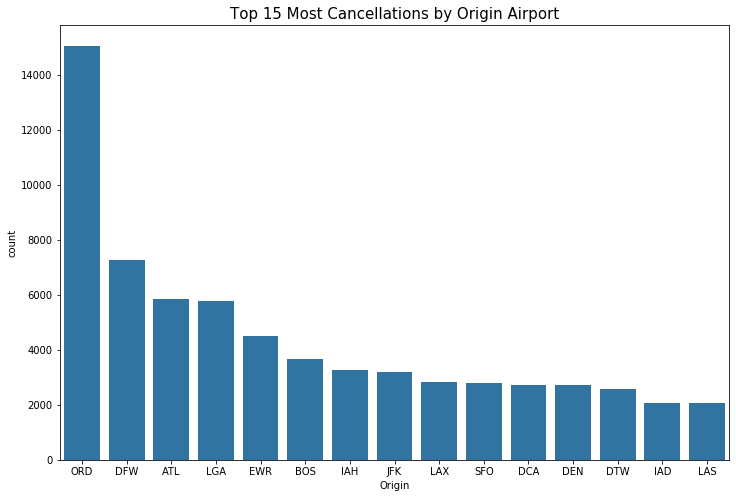

In [32]:
# Cancellations by Airports - most cancellations
base_color = sb.color_palette()[0]

top = (df_cancelled.Origin.value_counts()[0:15].index)
plt.figure(figsize=(12,8))
ax = sb.countplot(data = df_cancelled[df_cancelled.Origin.isin(top)], x='Origin', 
             color = base_color, order=top);
plt.title('Top 15 Most Cancellations by Origin Airport', fontsize=15);

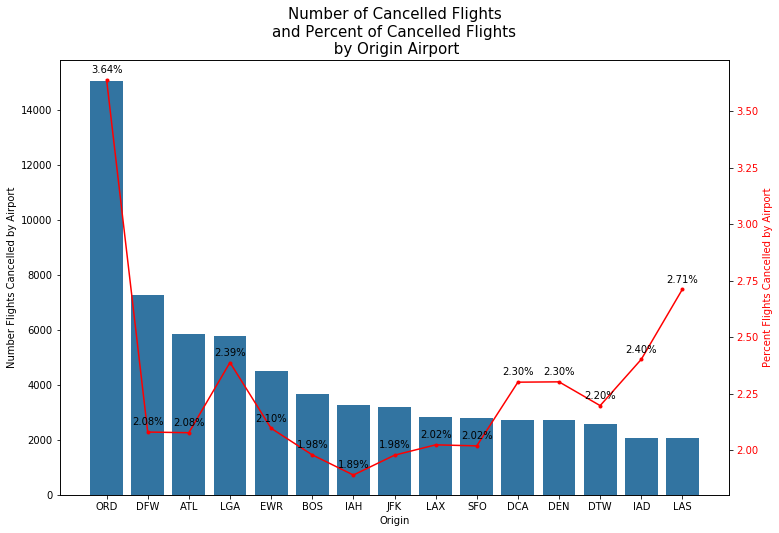

In [33]:
# % Cancelled Flights for the Top 15 Origina Airports with most cancellations
# ie. for each airport, the percentage of cancelled flights relative to that airport's total flights
# top = airport labels
top = (df_cancelled.Origin.value_counts()[0:15].index)
fig, ax1 = plt.subplots(figsize=(12,8))

ax1 = sb.countplot(data = df_cancelled[df_cancelled.Origin.isin(top)], x='Origin', 
             color = base_color, order=top);

n_points = df[df.Origin.isin(top)].Origin.value_counts().values
n_cancels = df_cancelled[df_cancelled.Origin.isin(top)].Origin.value_counts().values
locs = range(15)
locslabs = sorted(zip(locs, top, n_cancels, n_points), key=lambda x: x[1])

plt.title('Number of Cancelled Flights\nand Percent of Cancelled Flights\n by Origin Airport', fontsize=15);
ax1.set_ylabel('Number Flights Cancelled by Airport', color='k')  # we already handled the x-label with ax1

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
pct_cnl = 100* n_cancels/ n_points
# locs remains the same
ax2.plot(locs, pct_cnl, color='r', marker='.')
ax2.set_ylabel('Percent Flights Cancelled by Airport', color='r')  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor='r')
for loc, label, can, tot in locslabs:
    pct_str = '{:0.2f}%'.format(100*can/tot)
    plt.text(loc, 100*can/tot+0.03, pct_str, ha='center', color='k')

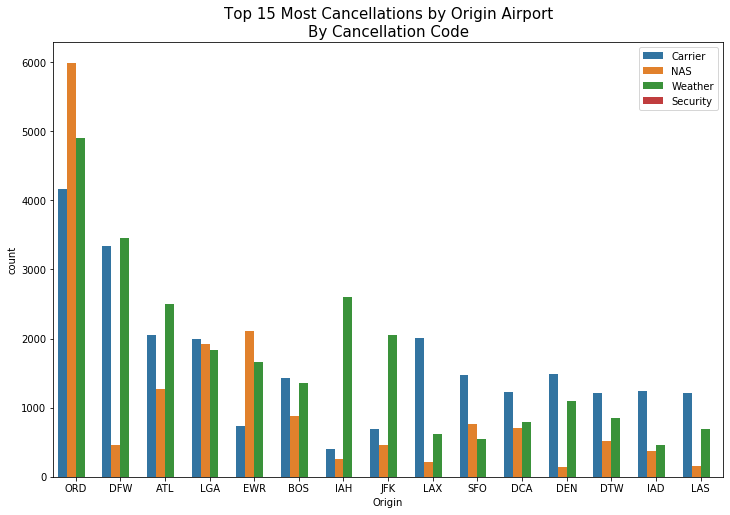

In [34]:
# Cancellations by Airports and codes - most cancellations
base_color = sb.color_palette()[0]

top = (df_cancelled.Origin.value_counts()[0:15].index)
plt.figure(figsize=(12,8))
ax = sb.countplot(data = df_cancelled[df_cancelled.Origin.isin(top)], x='Origin', 
             hue = 'CancellationCode', order=top);
plt.title('Top 15 Most Cancellations by Origin Airport\nBy Cancellation Code', fontsize=15);

plt.legend(['Carrier','NAS','Weather','Security']);

Although NAS can refer to weather as well, we will keep NAS and Weather separate and will distinguish the two, knowing that Weather related to Extreme Weather, while NAS may be more common weather scenarios. Aside from Chicago (ORD) and Newark (EWR), most of the top volume airports experience cancellations due to Carrier and Weather issues. However, considering that Chicago and Newark often experience snow during the winter, many of their NAS cancellations may also be caused by weather.

## When do Cancelled flights occur?
##### By Month

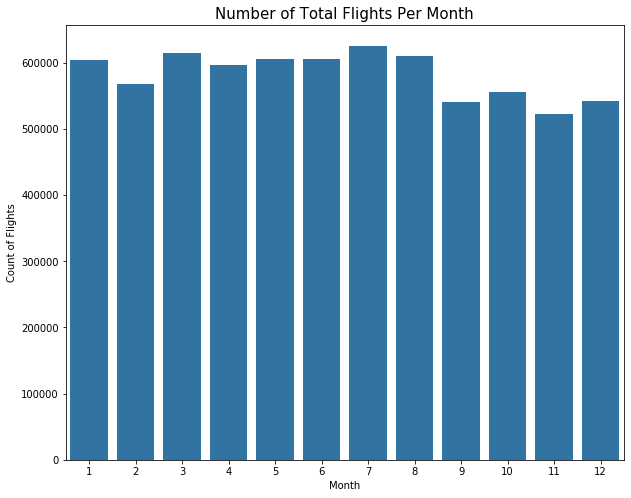

In [35]:
plt.figure(figsize=(10,8))
sb.countplot(data=df, x='Month', color=base_color);
plt.title("Number of Total Flights Per Month", fontsize=15);
plt.ylabel("Count of Flights");

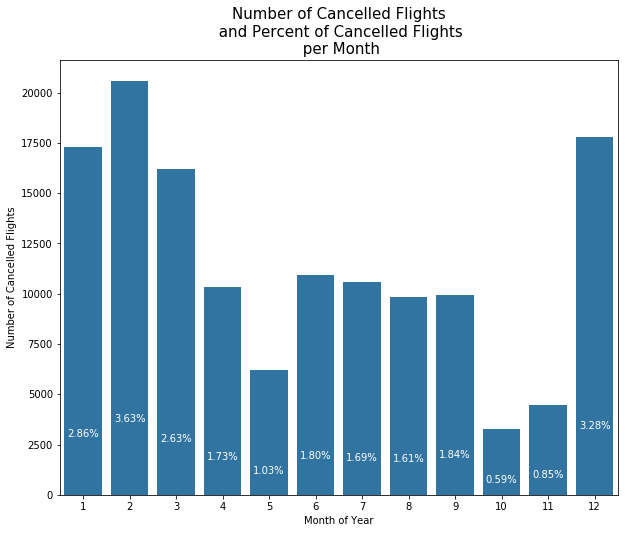

In [36]:
# Cancellations by month
plt.figure(figsize=(10,8))
sb.countplot(data=df_cancelled, x='Month', color=base_color);

tot_flights = df.Month.value_counts().sort_index().values
can_flights = df_cancelled.Month.value_counts().sort_index().values
locs = range(1,13)
locslabs = zip(locs, can_flights, tot_flights)

for loc, can, tot in locslabs:
    pct = 100*can/tot
    pct_str = '{:0.2f}%'.format(pct)
    plt.text(loc-1, pct*1000, pct_str, ha='center', color='w')
    
# plt.plot();
# plt.legend(['Percent Cancelled'], markerfirst=False, facecolor='w', scatterpoints=0);
plt.ylabel('Number of Cancelled Flights');
plt.xlabel('Month of Year');
plt.title('Number of Cancelled Flights\n and Percent of Cancelled Flights\n per Month', fontsize=15);

The most cancellations and the highest percentage of cancellations occur over the months of December, January, February, and March. This aligns with the findings above that most cancellations are related to weather or carrier. It would be interesting to see what types of cancellations occur during each month.

C:\Users\modhi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


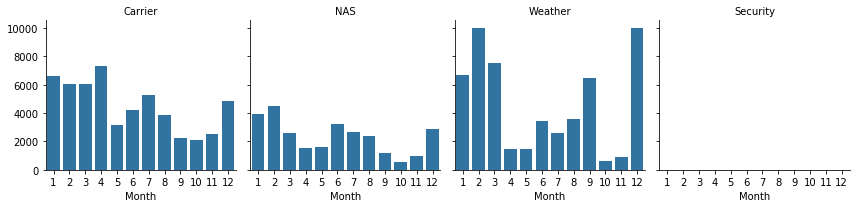

In [37]:
# Cancellation codes by month
df_cancelled['CancellationReason'] = df_cancelled['CancellationCode'].replace({'A': 'Carrier',
                                                              'B': 'Weather',
                                                               'C': 'NAS',
                                                                 'D': 'Security'})
                                                                 
g = sb.FacetGrid(df_cancelled, col="CancellationReason") 
g = g.map(sb.countplot, "Month", order=[1,2,3,4,5,6,7,8,9,10,11,12]).set_titles("{col_name}")

In the US, the most common delays over the winter/holiday months seems to be due to weather, followed by carrier, which is fairly consistent across all other months. NAS causes fewer cancellations, but also has slightly higher volumes during the winter months, which could also relate back to the weather sub-reason. Since there are only 12 examples of Security reasons causing cancellations those results are negligible.

##### By Day of Week

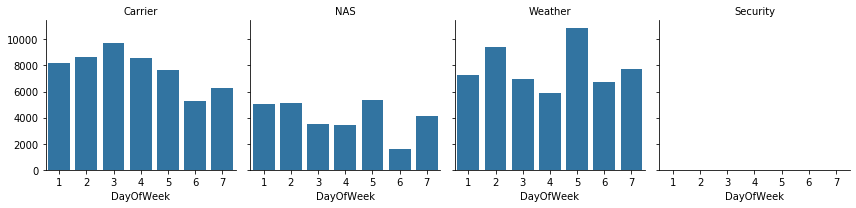

In [38]:
# Day of Week for Each Cancellation Code
g = sb.FacetGrid(df_cancelled, col="CancellationReason") 
g = g.map(sb.countplot, "DayOfWeek", order=[1,2,3,4,5,6,7]).set_titles("{col_name}")

Overall, there is not much of a difference between week days in terms of cancellations or cancellation codes. Saturday and Sunday have fewer flights in general, which leads them to have fewer cancellations relative to week days.

##### By Hour of Scheduled Departure

In [49]:
df['CRSDepTimeHour'] = df.CRSDepTime.apply(lambda x: x.hour)

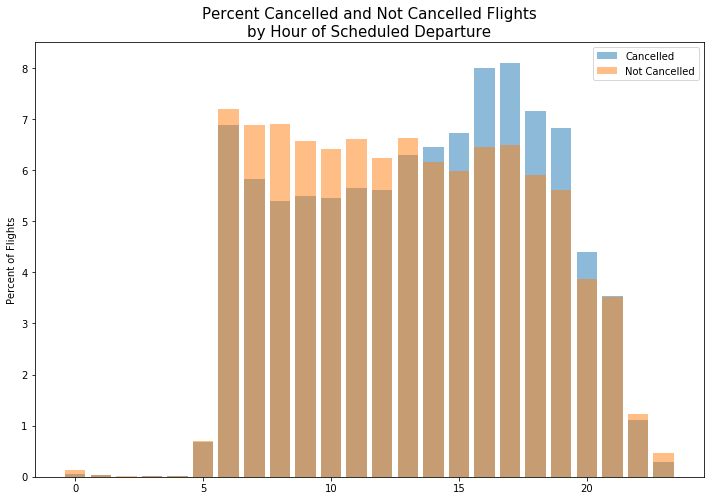

In [50]:
plt.figure(figsize=(12,8))

n_points_can = df[df.Cancelled==1].CRSDepTimeHour.value_counts().sort_index().values
n_cancels = df[df.Cancelled==1].shape[0]
pct_can = n_points_can / n_cancels*100

n_points = df[df.Cancelled==0].CRSDepTimeHour.value_counts().sort_index().values
n_nocan = df[df.Cancelled==0].shape[0]
pct_nocan = n_points / n_nocan*100
locs = range(24)

plt.bar(x=locs, height=pct_can, label='Cancelled', alpha=0.5);
plt.bar(x=locs, height=pct_nocan, label='Not Cancelled', alpha=0.5);
plt.legend();

plt.title('Percent Cancelled and Not Cancelled Flights\nby Hour of Scheduled Departure', fontsize=15);
plt.ylabel('Percent of Flights', color='k');  # we already handled the x-label with ax1'''

Most flights occur between 5am and 8pm, with a slightly higher percentage of cancellations occurring during the evening hours of 2pm to 8pm. This cannot truly be connected back to weather or carrier cancellations, but may have something to do with a decrease in visibility as the sun begins to go down after noon.

### Cancellations by Unique Carrier

In [44]:
len(df.UniqueCarrier.value_counts().index)

20

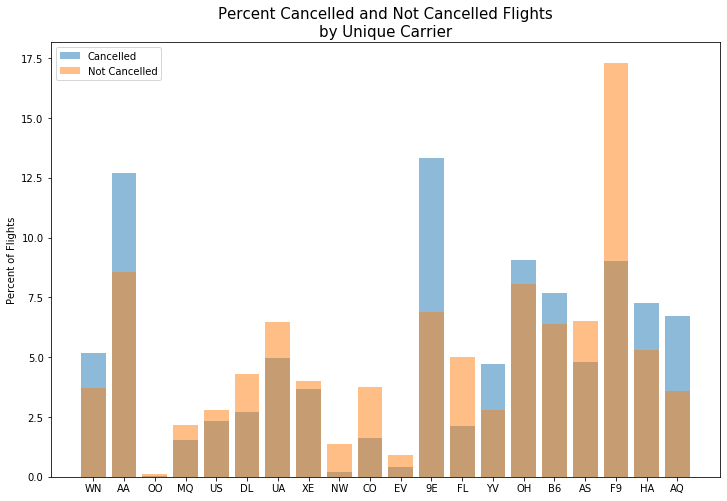

In [45]:

plt.figure(figsize=(12,8))

n_points_can = df[df.Cancelled==1].UniqueCarrier.value_counts().sort_index().values
n_cancels = df[df.Cancelled==1].shape[0]
pct_can = n_points_can / n_cancels*100

n_points = df[df.Cancelled==0].UniqueCarrier.value_counts().sort_index().values
n_nocan = df[df.Cancelled==0].shape[0]
pct_nocan = n_points / n_nocan*100
locs = np.arange(0,20,1)

plt.bar(x=locs, height=pct_can, label='Cancelled', alpha=0.5);
plt.bar(x=locs, height=pct_nocan, label='Not Cancelled', alpha=0.5);
plt.legend();
plt.xticks(locs, list(df.UniqueCarrier.value_counts().index));

plt.title('Percent Cancelled and Not Cancelled Flights\nby Unique Carrier', fontsize=15);
plt.ylabel('Percent of Flights', color='k');  # we already handled the x-label with ax1

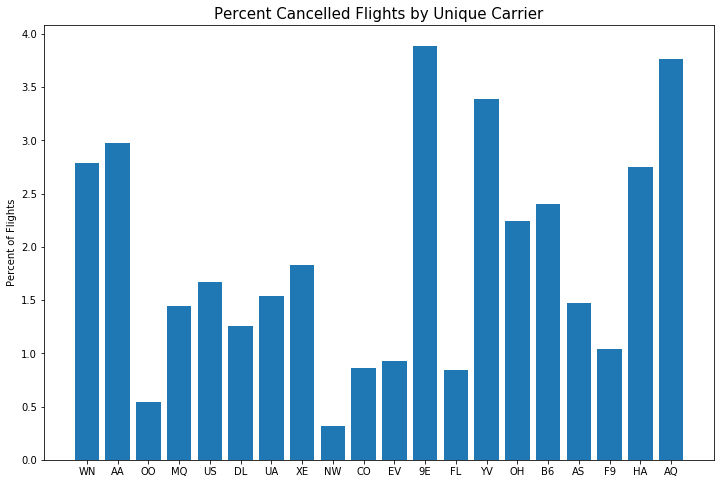

In [46]:
plt.figure(figsize=(12,8))

n_points_can = df[df.Cancelled==1].UniqueCarrier.value_counts().sort_index().values
n_points = df[df.Cancelled==0].UniqueCarrier.value_counts().sort_index().values
pct_can = n_points_can / n_points*100

locs = np.arange(0,20,1)

plt.bar(x=locs, height=pct_can, label='Cancelled');
plt.xticks(locs, list(df.UniqueCarrier.value_counts().index));

plt.title('Percent Cancelled Flights by Unique Carrier', fontsize=15);
plt.ylabel('Percent of Flights', color='k');

Some carriers have a higher percentage of cancellations than others: WN, AA, 9E, YV, OH, B6, HA, AQ. These may be interesting to examine closer and see if they correlate with the cancellation code, time, distance, or departing airports which also exhibited more cancellations relatively.

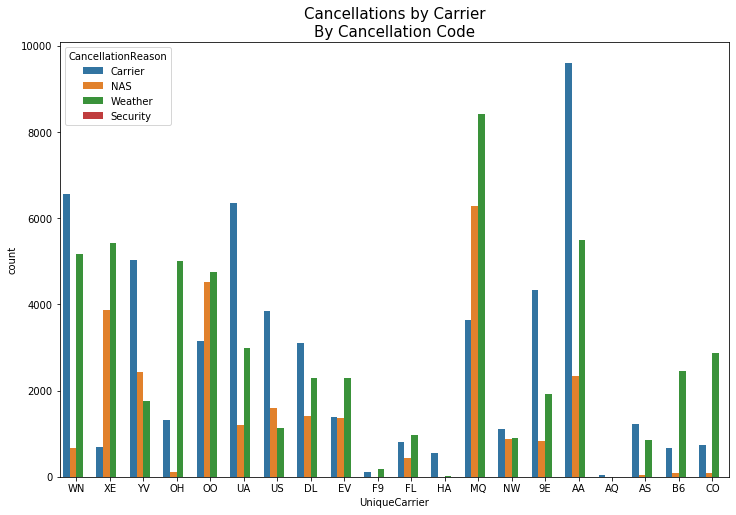

In [47]:
# Cancellations by Carriers and codes 
base_color = sb.color_palette()[0]

top = (df_cancelled.UniqueCarrier.value_counts().index)
plt.figure(figsize=(12,8))
ax = sb.countplot(data = df_cancelled, x='UniqueCarrier', 
             hue = 'CancellationReason');
plt.title('Cancellations by Carrier\nBy Cancellation Code', fontsize=15);

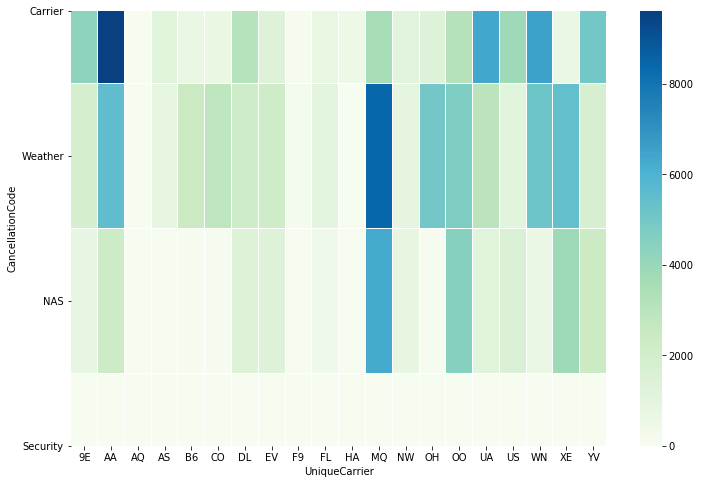

In [48]:
# Cancellations due to Carrier and Carriers - Summation
plt.figure(figsize=(12,8))
df_sub = df_cancelled[['UniqueCarrier','CancellationCode','Cancelled']]
df_subpiv = df_sub.pivot_table(index='CancellationCode', columns='UniqueCarrier', 
                               values='Cancelled', fill_value=0, aggfunc='sum')
ax = sb.heatmap(df_subpiv, cmap='GnBu', linewidths=0.01);
locs,labels = plt.yticks();
plt.yticks(locs, ['Carrier', 'Weather','NAS','Security'], rotation=0);

### Conclusions<br/>
After comparing cancellations to various flight aspects one by one, we can narrow down the leading factors of cancellation to a few factors, with some that overlap each other. The main contributing factors are month of the year, origin airport, carrier, and distance, with the leading causes being weather, carrier, and in part, NAS (National Aviation Service). Beginning with time of year, the most cancellations (and highest percentage of cancellations) occurred during the months of December, January, February, and March. Within those months, the majority of cancelled flights were cancelled due to weather; overall, most flights were cancelled due to weather, carrier, then NAS, with NAS also including a sub-reason related to weather. Weather cancellations during winter months seems to make sense, as snow storms in the US can be extreme enough to ground flights. Narrowing in on these higher volumes of cancelled flights, we begin to see that they are also tied to origin airports, carriers, and distance. These three other factors are also correlated with each other; each airport only supports certain carriers and certain destinations, while each carrier only goes to certain airports, which also limits the destinations to which carriers can travel. Altogether, the corresponding limits on origin-carrier-distance combinations lend themselves to an overall correlation to location and weather, which is one of the leading causes of cancellations, as well as carrier, which is another leading cause of cancellations. We can narrow down the most predictive features of cancelled flights by finding the combinations of month, origin airport, carrier, and distance (or technically also destination) where the highest percentages of cancellations fall.

Luckily, cancellations made up a very small percentage of all flights during 2008 (only about 0.02% of almost 7 million total flights), and an even smaller number actually spent time on the tarmac, so in general, you had to be very unlucky to actually step onto a flight that wouldn't successfully take off.

Because this dataset only covers flights from one year, we cannot make any assumptions about predictions or yearly trends, but we can get a good idea of where to look in future broader analyses.


In [51]:
df.to_csv('cleaned_flights.csv')